# Performance Attribution
In this exercise, we're going to use artificial data and a PCA risk model to show you the nuts and bolts of performance attribution. We use artificial data here so that you can focus on the calculations without having to worry about extra packages and data details. Let's get started!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import plotly as py
import plotly.graph_objs as go
import helper
from scipy.stats import zscore
import statsmodels.api as sm


py.offline.init_notebook_mode(connected=True)
%matplotlib inline
plt.style.use('ggplot')

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



### Load the data
These will be our example price data.

In [2]:
prices = pd.read_csv('stock_prices_attribution.csv', parse_dates=['date'], index_col=0)

In [3]:
prices.head()

,A,B,C
date,,,
2013-07-02,100.000000,102.000000,104.000000
2013-07-03,100.350611,102.209243,104.589219
2013-07-05,100.724889,101.640083,100.913246
2013-07-08,100.742305,102.861043,103.910356
2013-07-09,101.360592,102.182024,101.238888


In [4]:
rets = prices.pct_change()[1:].fillna(0)

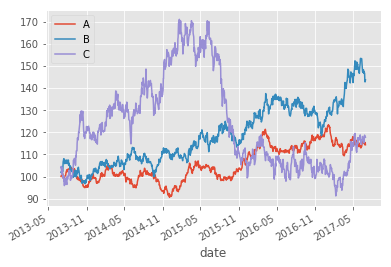

In [5]:
prices.plot()

This will be our example alpha factor.

In [6]:
# 1-yr momentum alpha

def log_returns(series):
    return np.log(series[-1])-np.log(series[0])
    
alpha = prices.rolling(window=252).apply(log_returns, raw=True).rank(axis='columns').apply(zscore, axis='columns', raw=True)

In [7]:
# Take most recent set of values
alpha_vector = alpha.iloc[-1]
print(alpha_vector)

A   -1.224745
B    0.000000
C    1.224745
Name: 2017-06-30 00:00:00, dtype: float64


### Risk model
Let's build a PCA risk model.

In [9]:
m = rets.mean()
rets = rets - m

In [10]:
from sklearn.decomposition import PCA

class RiskModelPCA():
    
    ANN_FACTOR = 252
    
    def __init__(self, num_factors):
        self._num_factors = num_factors
        self.num_stocks_ = None
        self.factor_betas_ = None
        self.factor_returns_ = None
        self.common_returns_ = None
        self.residuals_ = None
        self.factor_cov_matrix_ = None
        self.idio_var_matrix_ = None
        self.explained_variance_ratio_ = None

    def fit(self, returns):
        self.num_stocks_ = len(returns.columns)
        mod = PCA(n_components=self._num_factors, svd_solver='full')
        mod.fit(returns)
        
        self.factor_betas_ = pd.DataFrame(
            data=mod.components_.T,
            index=returns.columns
        )
        
        self.factor_returns_ = pd.DataFrame(
            data=mod.transform(returns),
            index=returns.index
        )
        
        self.explained_variance_ratio_ = mod.explained_variance_ratio_
        
        self.common_returns_ = pd.DataFrame(
            data=np.dot(self.factor_returns_, self.factor_betas_.T),
            index=returns.index
        )
        self.common_returns_.columns = returns.columns
        
        self.residuals_ = (returns - self.common_returns_)
        
        self.factor_cov_matrix_ = np.diag(
            self.factor_returns_.var(axis=0, ddof=1)*RiskModelPCA.ANN_FACTOR
        )
        
        self.idio_var_matrix_ = pd.DataFrame(
            data=np.diag(np.var(self.residuals_))*RiskModelPCA.ANN_FACTOR,
            index=returns.columns
        )
        
        self.idio_var_vector_ = pd.DataFrame(
            data=np.diag(self.idio_var_matrix_.values),
            index=returns.columns
        )
        
        self.idio_var_matrix_.columns = index=returns.columns

    def get_factor_exposures(self, weights):
        B = self.factor_betas_.loc[weights.index]
        return B.T.dot(weights)

In [11]:
rm = RiskModelPCA(2) # create an instance of the class with 2 factors
rm.fit(rets.iloc[:-2,:]) # fit the model on all the data up to 2 days before the last day

The part that we're going to use from the risk model is the _risk model exposures_. Can you remember how to extract them from the fitted risk model?

In [12]:
# TODO: Write the code to extract the "B" matrix from the fitted risk model.
B = rm.factor_betas_

Let's make a plot to remember what we have so far.

In [13]:
PC_scaler = 0.04 # The PC vectors have length 1, but this is larger than the scale of our data, so for visualization purposes, let's plot scaled-down versions of the PCs. 

# Trace for PC 0
pc0 = np.vstack((np.full(3, 0), rm.factor_betas_[0].values)).T*PC_scaler

hover_text4 = helper.generate_hover_text(pc0[0], pc0[1], pc0[2], 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace4 = go.Scatter3d(
    x=pc0[0],
    y=pc0[1],
    z=pc0[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='#45B39D',
        opacity=0.9,
        symbol="diamond"
    ),
    line=dict(
        color='#45B39D',
        width=3
    ),
    name = 'PC 0',
    text = hover_text4.flatten(),
    hoverinfo = 'text'

)

# Trace for PC 1
pc1 = np.vstack((np.full(3, 0), rm.factor_betas_[1].values)).T*PC_scaler

hover_text5 = helper.generate_hover_text(pc1[0], pc1[1], pc1[2], 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace5 = go.Scatter3d(
    x=pc1[0],
    y=pc1[1],
    z=pc1[2],
    mode='lines+markers',
    marker=dict(
        size=4,
        color='#FFC300',
        opacity=0.9,
        symbol="diamond"
    ),
    line=dict(
        color='#FFC300',
        width=3
    ),
    name = 'PC 1',
    text = hover_text5.flatten(),
    hoverinfo = 'text'

)

# Trace for data
hover_text6 = helper.generate_hover_text(rets['A'].iloc[:-2].values, rets['B'].iloc[:-2].values, rets['C'].iloc[:-2].values, 'Return of Stock A', 'Return of Stock B', 'Return of Stock C')

trace6 = go.Scatter3d(
    x=rets['A'].values,
    y=rets['B'].values,
    z=rets['C'].values,
    mode='markers',
    marker=dict(
        size=4,
        color='#7FB3D5', 
        opacity=0.3,
    ),
    name = 'daily returns',
    text = hover_text6.flatten(),
    hoverinfo = 'text'
)

data = [trace4, trace5, trace6]

layout = helper.create_standard_layout('Returns Data with Factor (PC) Directions', 'Return of')
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### Factor Returns
We're going to calculate the factor returns in a slightly different way than we did back when we studied risk models with PCA. We want to estimate the factor returns of our entire model, including both risk and alpha factors, so we're going to fit a least squares regression model to the risk factors and alpha factor we've come up with, in order to estimate the factor returns. We're going to run the regression for a single time period only—the last one our dataset covers.

In [17]:
# create an r vector for a single time period (the last time period)
r = rets.iloc[-1,:]

In [18]:
estu = B.rename({0:'risk_factor_zero', 1:'risk_factor_one'}, axis='columns')
estu['alpha'] = alpha_vector
estu['return'] = r
estu

,risk_factor_zero,risk_factor_one,alpha,return
A,0.009675,0.018538,-1.224745,-0.007382
B,0.019312,0.999638,0.000000,0.004861
C,0.999767,-0.019489,1.224745,-0.002491


In [19]:
# TODO: use statsmodels.OLS to fit an ordinary linear regression model to `return`, as a function of `risk_factor_zero`
# `risk_factor_one`, and `alpha`
model = sm.OLS(estu['return'],estu[['risk_factor_zero','risk_factor_one','alpha']])
results = model.fit()

Let's take a look at the results.

In [20]:
factor_returns = results.params
factor_returns

risk_factor_zero   -0.009776
risk_factor_one     0.005051
alpha               0.006027
dtype: float64

The idiosyncratic term comes from the model's residuals.

In [21]:
s = results.resid
s

A    2.602085e-18
B   -1.821460e-17
C   -6.938894e-18
dtype: float64

### Exposure Vector
Let's do our performance attribution for a single time period—the last one our dataset covers. Now let's assume that we've run our optimization and come up with a set of holdings we wish to take on Stocks A, B and C. Let's say we want to go \\$500k short on Stock B and \\$500k long on Stock C.

In [22]:
h = pd.Series({'A': 0, 'B': -500000, 'C': 500000})
h

A         0
B   -500000
C    500000
dtype: int64

Now, let's add our alpha factor to the B matrix, so that B contains _both alpha and risk factors_, as explained in the lecture.

In [23]:
B = B.rename({0:'risk_factor_zero', 1:'risk_factor_one'}, axis='columns')
B['alpha'] = alpha_vector
B

,risk_factor_zero,risk_factor_one,alpha
A,0.009675,0.018538,-1.224745
B,0.019312,0.999638,0.000000
C,0.999767,-0.019489,1.224745


Now let's calculate the exposure vector: $\mathbf{B}^T \mathbf{h}$.

In [25]:
# TODO: Calculate the exposure vector.
E = B.T.dot(h)
E

risk_factor_zero    490227.482019
risk_factor_one    -509563.426113
alpha               612372.435696
dtype: float64

### The profit calculation
The total portfolio pnl is $h^Tr$.

In [26]:
# TODO: Calculate the total pnl.
total_pnl = h.T.dot(r)
print('Total pnl: ', total_pnl)

Total pnl:  -3676.03547723


### Performance Attribution
Now let's calculate the factor contributions.

In [27]:
# TODO: Calculate the contribution to pnl due to alpha
alpha_contribution = E['alpha']*factor_returns['alpha']
alpha_contribution

3690.6507934360025

In [28]:
# TODO: Calculate the contribution to pnl due to factor zero
factor_zero_contribution = E['risk_factor_zero']*factor_returns['risk_factor_zero']
factor_zero_contribution

-4792.6745247505978

In [29]:
# TODO: Calculate the contribution to pnl due to factor one
factor_one_contribution = E['risk_factor_one']*factor_returns['risk_factor_one']
factor_one_contribution

-2574.0117459142343

In [30]:
total_factor_pnl =  alpha_contribution + factor_zero_contribution + factor_one_contribution

Now let's calculate the idiosyncratic pnl.

In [31]:
# TODO: Calculate the idiosyncratic pnl.
print('Idiosyncratic pnl: ', h.T.dot(s))

Idiosyncratic pnl:  5.63785129692e-12


If you need some help on this exercise, check out the [solution notebook](performance_attribution_solution.ipynb).